### GAN

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
# 划分数据集
def split_dataset(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    # normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # normal data
    X_normal = X[Y == 0]
    Y_normal = Y[Y == 0]

    # abnormal data
    X_abnormal = X[Y == 1]
    Y_abnormal = Y[Y == 1]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_normal, Y_normal, test_size=0.2, random_state=2023)
    
    # 拼接X_test和X_abnormal
    X_test = np.concatenate((X_test, X_abnormal), axis=0)
    y_test = np.concatenate((y_test, Y_abnormal), axis=0)

    # # 将时间序列数据转换为适用于LSTM自编码器的输入格式
    # X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    # X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    return X_train, X_test, y_train, y_test

from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
def pick_threshold(y, preds):
    thresholds = np.linspace(0.1, 10, 500)
    f1_scores = [f1_score(y, preds > t) for t in thresholds]
    precision_scores = [precision_score(y, preds > t) for t in thresholds]
    recall_scores = [recall_score(y, preds > t) for t in thresholds]
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.plot(thresholds, precision_scores, label='Precision')
    plt.plot(thresholds, recall_scores, label='Recall')
    plt.axvline(x=thresholds[np.argmax(f1_scores)], color='r', linestyle='--', label='Max F1 Score')
    plt.title('F1 Score w.r.t varying threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    best_threshold = thresholds[np.argmax(f1_scores)]
    print('Best threshold: ', best_threshold)
    print('Best F1 Score: ', np.max(f1_scores))
    print('Recall: ', recall_score(y, preds > best_threshold))
    print('Precision: ', precision_score(y, preds > best_threshold))
    

    cm = confusion_matrix(y, preds > best_threshold)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return best_threshold

In [17]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential
from keras import models
from keras.optimizers import Adam
import tensorflow as tf

# Define the Autoencoder generator
def build_generator(input_dim, output_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(32, activation='relu', use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(16, activation='relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(16, activation='relu')(x)
    x = BatchNormalization()(x) 
    x = LeakyReLU(0.2)(x)

    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x) 
    x = LeakyReLU(0.2)(x)

    output_layer = Dense(output_dim)(x)
    generator = Model(input_layer, output_layer, name='generator')
    return generator

# Define the Discriminator
def build_discriminator(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(32, use_bias=False)(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x= Dropout(0.3)(x)
    output_layer = Dense(1)(x)

    discriminator = Model(input_layer, output_layer, name='discriminator')
    return discriminator

# Build GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False  # To prevent training the discriminator when training the GAN

    gan_input = Input(shape=(generator.input_shape[1],))
    generated_data = generator(gan_input)
    gan_output = discriminator(generated_data)

    gan = Model(gan_input, gan_output, name='gan')
    return gan

# Training the GAN
def train_gan(x_train, epochs=2000, batch_size=32):
    # set random seed
    tf.random.set_seed(2023)    
    # Define hyperparameters
    input_dim = 12
    output_dim = 12
    batch_size = batch_size
    epochs = epochs

    # Build and compile the models
    generator = build_generator(input_dim, output_dim)
    discriminator = build_discriminator(output_dim)
    gan = build_gan(generator, discriminator)

    # 编译模型
    generator.compile(loss='mse', optimizer=Adam(learning_rate=0.0002))
    gan.compile(loss='mse', optimizer=Adam(learning_rate=0.0002))

    discriminator.trainable = True
    discriminator.compile(loss='mse', optimizer=Adam(learning_rate=0.0002))
    

    d_loss_ = []
    g_loss_ = []
    for epoch in range(epochs):
        # Train the discriminator
        # Select a random batch of real data
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_data = x_train[idx]

        # Generate fake data
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        generated_data = generator.predict(noise)

        # One-hot encoding of the labels: fake data = 0, real data = 1
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
        # Average loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (via the GAN model)
        noise = np.random.normal(0, 1, (batch_size, input_dim))
        valid_labels = np.ones((batch_size, 1))

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print the progress
        print(f"Epoch {epoch}/{epochs}, D Loss: {d_loss[0]}, D Accuracy: {100 * d_loss[1]}, G Loss: {g_loss}")

        # save d_loss and g_loss
        d_loss_.append(d_loss[0])
        g_loss_.append(g_loss)
    
    # # plot the loss
    # plt.plot(d_loss_)
    # plt.plot(g_loss_)
    # plt.title('GAN loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['Discriminator', 'Generator'], loc='upper left')
    # plt.show()
    
    return generator


# 训练模型
def train_model(time_freq, epochs=2000, batch_size=32):
    X_train, X_test, y_train, y_test = split_dataset(time_freq)
    generator = train_gan(X_train, epochs, batch_size)

    return generator, X_train, X_test, y_train, y_test

# 25S

In [16]:
generator, X_train, X_test, y_train, y_test =train_model('25S', 1000, 128)

4/4 [==============================] - 0s 1ms/step
Epoch 0/1000, D Loss: 0.7178222239017487, D Accuracy: 53.515625, G Loss: 0.8585249781608582
4/4 [==============================] - 0s 1ms/step
Epoch 1/1000, D Loss: 0.7262388169765472, D Accuracy: 51.5625, G Loss: 0.8851014375686646
4/4 [==============================] - 0s 1ms/step
Epoch 2/1000, D Loss: 0.7155581116676331, D Accuracy: 54.296875, G Loss: 0.8662207722663879
4/4 [==============================] - 0s 1000us/step
Epoch 3/1000, D Loss: 0.718443900346756, D Accuracy: 53.90625, G Loss: 0.8495882749557495
4/4 [==============================] - 0s 1ms/step
Epoch 4/1000, D Loss: 0.7468938827514648, D Accuracy: 49.609375, G Loss: 0.8593454360961914
4/4 [==============================] - 0s 1ms/step
Epoch 5/1000, D Loss: 0.7281144559383392, D Accuracy: 53.90625, G Loss: 0.8601920008659363
4/4 [==============================] - 0s 1000us/step
Epoch 6/1000, D Loss: 0.7379198670387268, D Accuracy: 51.171875, G Loss: 0.851772069931030

KeyboardInterrupt: 

3022/3022 [==============================] - 2s 590us/step
Anomaly Scores: [ 1.03571491  0.72449265  0.79618519 ... 13.20064879  1.62984081
 16.80014871]


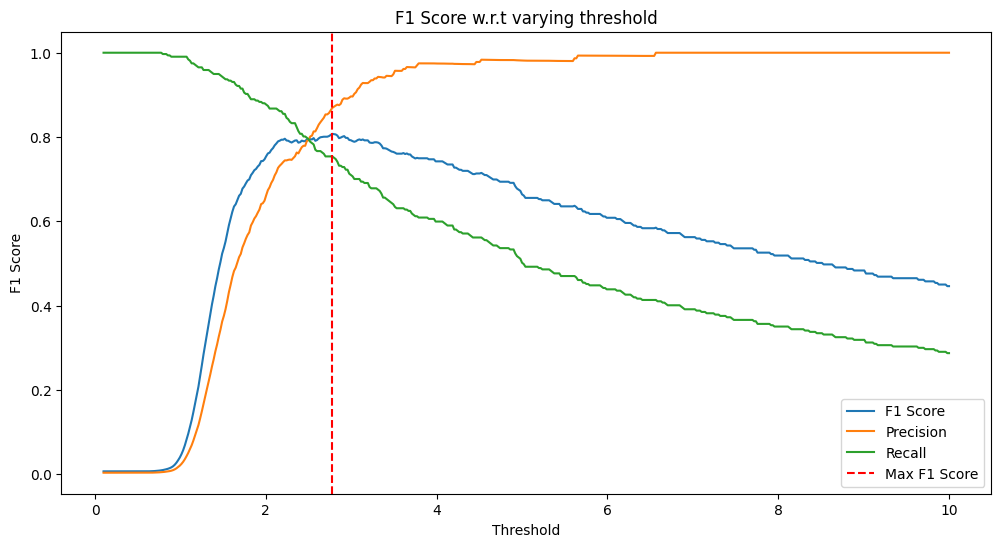

Best threshold:  2.778356713426854
Best F1 Score:  0.8074324324324325
Recall:  0.7539432176656151
Precision:  0.8690909090909091


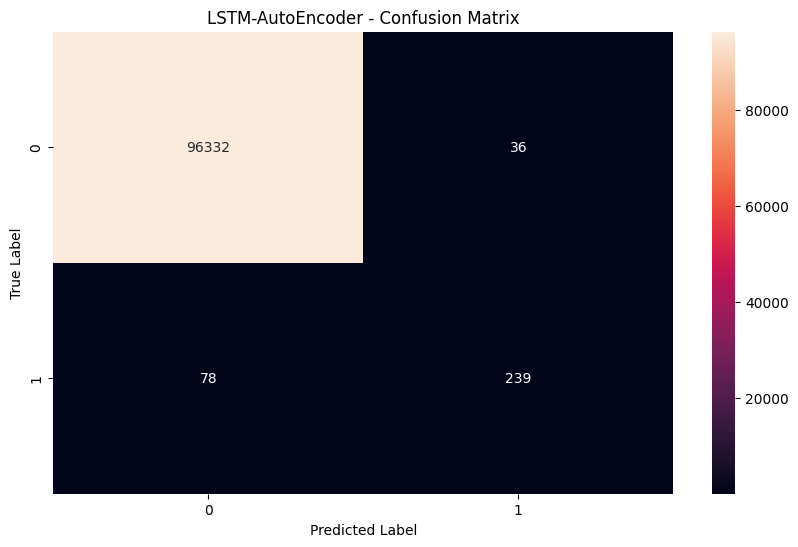

2.778356713426854

In [34]:
# 使用X_test作为输入，生成正常样本
# 1 为正常，0 为异常
generated_data = generator.predict(X_test)

# 计算输入样本与生成异常样本之间的重构误差作为异常分数 MAE
reconstruction_errors = np.mean(np.abs(generated_data - X_test), axis=1)

# 打印异常分数
print("Anomaly Scores:", reconstruction_errors)

pick_threshold(y_test, reconstruction_errors)

# 15S

In [29]:
generator, X_train, X_test, y_train, y_test =train_model('15S', 1000, 128)

4/4 [==============================] - 0s 1ms/step
Epoch 0/1000, D Loss: 0.6711029559373856, D Accuracy: 66.015625, G Loss: 1.0556365251541138
4/4 [==============================] - 0s 1000us/step
Epoch 1/1000, D Loss: 0.6666653454303741, D Accuracy: 70.3125, G Loss: 1.078782320022583
4/4 [==============================] - 0s 1000us/step
Epoch 2/1000, D Loss: 0.629927322268486, D Accuracy: 72.65625, G Loss: 1.063647985458374
4/4 [==============================] - 0s 1ms/step
Epoch 3/1000, D Loss: 0.6517222821712494, D Accuracy: 68.359375, G Loss: 1.027032494544983
4/4 [==============================] - 0s 1ms/step
Epoch 4/1000, D Loss: 0.62880539894104, D Accuracy: 70.3125, G Loss: 1.0869089365005493
4/4 [==============================] - 0s 1ms/step
Epoch 5/1000, D Loss: 0.6578564941883087, D Accuracy: 71.875, G Loss: 1.072611689567566
4/4 [==============================] - 0s 1ms/step
Epoch 6/1000, D Loss: 0.6414365619421005, D Accuracy: 66.40625, G Loss: 1.0891332626342773
4/4 [====

3659/3659 [==============================] - 2s 594us/step
Anomaly Scores: [ 0.32312281  0.30229283  0.54416044 ... 16.59995345  1.7281522
 24.23511902]


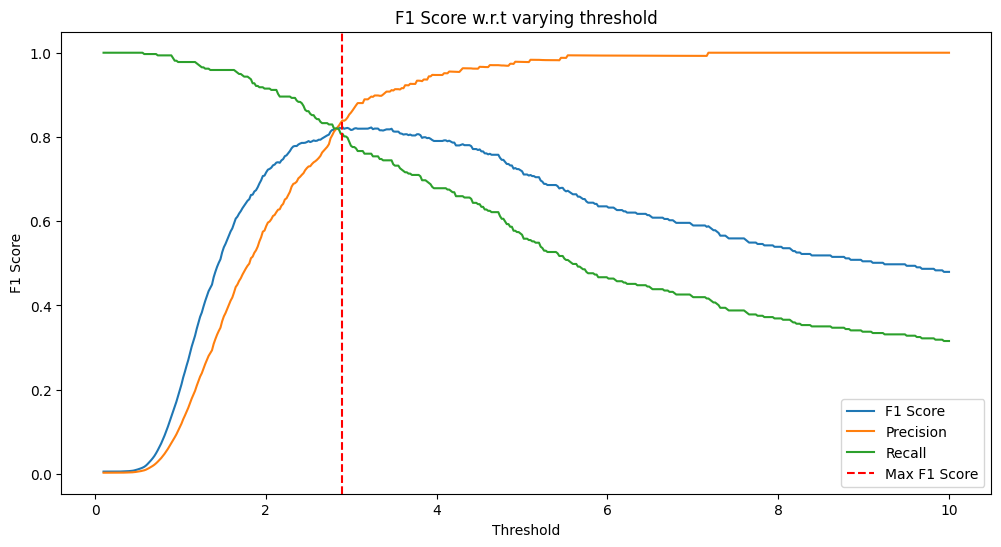

Best threshold:  2.8973947895791587
Best F1 Score:  0.8231511254019291
Recall:  0.807570977917981
Precision:  0.839344262295082


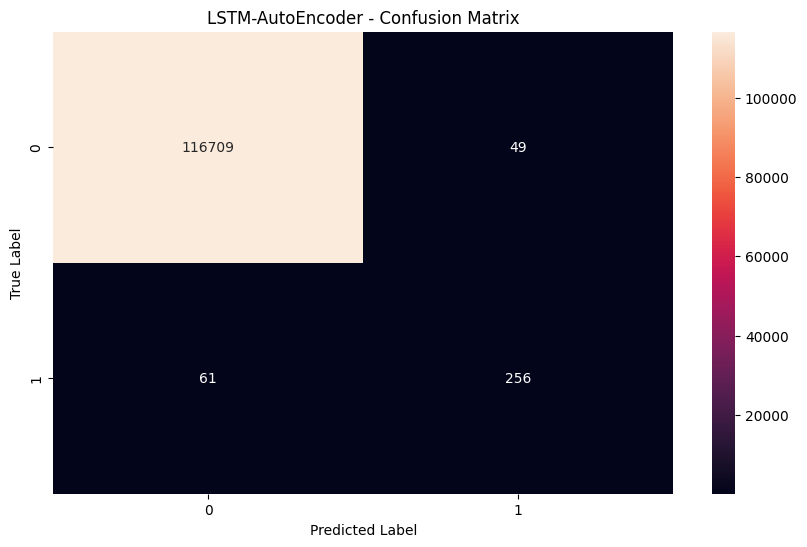

2.8973947895791587

In [30]:
# 使用X_test作为输入，生成正常样本
# 1 为正常，0 为异常
generated_data = generator.predict(X_test)

# 计算输入样本与生成异常样本之间的重构误差作为异常分数 MAE
reconstruction_errors = np.mean(np.abs(generated_data - X_test), axis=1)

# 打印异常分数
print("Anomaly Scores:", reconstruction_errors)

pick_threshold(y_test, reconstruction_errors)

# 5S

In [27]:
generator, X_train, X_test, y_train, y_test =train_model('5S', 1000, 128)

4/4 [==============================] - 0s 1ms/step
Epoch 0/1000, D Loss: 0.6467216908931732, D Accuracy: 68.75, G Loss: 0.7861301898956299
4/4 [==============================] - 0s 1ms/step
Epoch 1/1000, D Loss: 0.6438876688480377, D Accuracy: 71.484375, G Loss: 0.7964725494384766
4/4 [==============================] - 0s 1ms/step
Epoch 2/1000, D Loss: 0.653320848941803, D Accuracy: 67.1875, G Loss: 0.7892532348632812
4/4 [==============================] - 0s 1000us/step
Epoch 3/1000, D Loss: 0.6715770661830902, D Accuracy: 61.328125, G Loss: 0.8024187088012695
4/4 [==============================] - 0s 1ms/step
Epoch 4/1000, D Loss: 0.6365134716033936, D Accuracy: 72.265625, G Loss: 0.7882037162780762
4/4 [==============================] - 0s 1ms/step
Epoch 5/1000, D Loss: 0.6581881642341614, D Accuracy: 63.671875, G Loss: 0.8053807616233826
4/4 [==============================] - 0s 1ms/step
Epoch 6/1000, D Loss: 0.6400932967662811, D Accuracy: 68.75, G Loss: 0.7863733172416687
4/4 [==

5142/5142 [==============================] - 3s 579us/step
Anomaly Scores: [ 0.65480254  0.93454238  0.3606369  ... 25.94035179  1.50326114
 25.97942335]


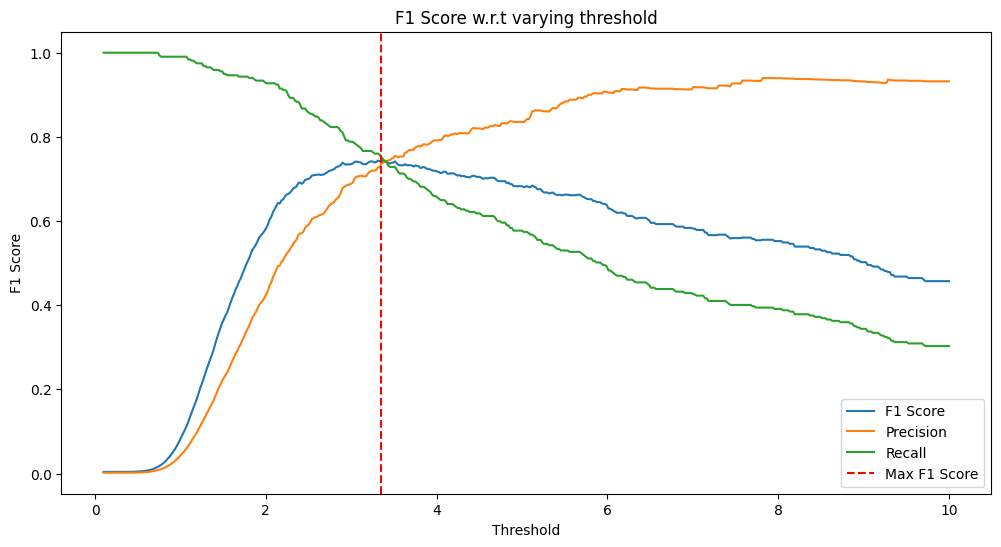

Best threshold:  3.3537074148296595
Best F1 Score:  0.7449139280125195
Recall:  0.750788643533123
Precision:  0.7391304347826086


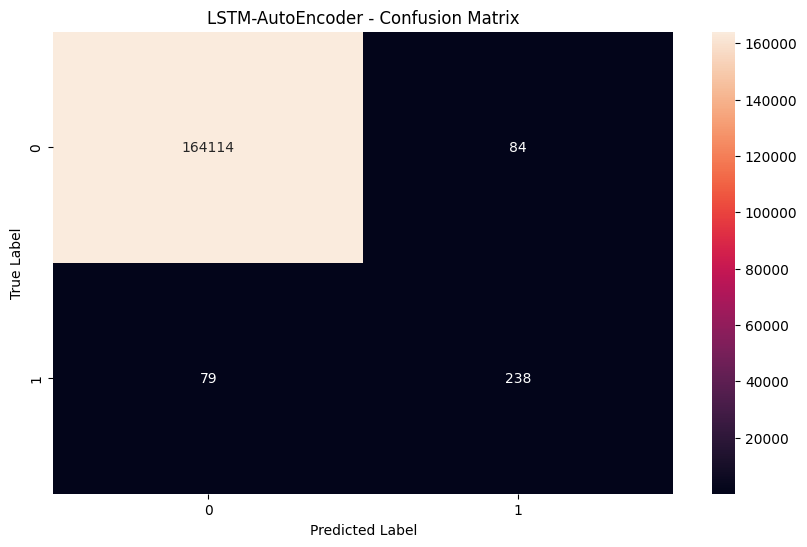

3.3537074148296595

In [28]:
# 使用X_test作为输入，生成正常样本
# 1 为正常，0 为异常
generated_data = generator.predict(X_test)

# 计算输入样本与生成异常样本之间的重构误差作为异常分数 MAE
reconstruction_errors = np.mean(np.abs(generated_data - X_test), axis=1)

# 打印异常分数
print("Anomaly Scores:", reconstruction_errors)

pick_threshold(y_test, reconstruction_errors)